In [1]:
import pathlib

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, ScalarFormatter
import numpy as np
import seaborn as sns

In [2]:
results_dir = pathlib.Path('results')

plot_data = []
for p in (results_dir / 'flora').iterdir():
    if p.is_dir():
        # parse the directory name
        args = p.name.split('-')
        if len(args) <= 1:
            continue

        # get the args from the dir name
        rand_distribution = None
        rank = None
        clip_norm = None
        for arg in args:
            if arg.startswith('rand_distribution_'):
                rand_distribution = arg[len('rand_distribution_'):]
            elif arg.startswith('rank_'):
                rank = int(arg[len('rank_'):])
            elif arg.startswith('clip_norm_'):
                clip_norm = (arg[len('clip_norm_'):] == 'True')
        if rand_distribution is None or rank is None or clip_norm is None:
            continue

        # load the losses
        train_losses = np.load(p / 'train_losses.npy')
        validation_losses = np.load(p / 'validation_losses.npy')
        df_train = pd.DataFrame({
            'loss_type': 'train',
            'loss': train_losses / train_losses[0],
            'rand_distribution': rand_distribution,
            'rank': rank,
            'clip_norm': clip_norm,
            'epoch': np.arange(len(train_losses))
        })

        df_validation = pd.DataFrame({
            'loss_type': 'validation',
            'loss': validation_losses / validation_losses[0],
            'rand_distribution': rand_distribution,
            'rank': rank,
            'clip_norm': clip_norm,
            'epoch': np.arange(len(validation_losses))
        })

        plot_data.append(df_train)
        plot_data.append(df_validation)

plot_data = pd.concat(plot_data)
plot_data

,loss_type,loss,rand_distribution,rank,clip_norm,epoch
0,train,1.000000,normal,8,False,0
1,train,0.999678,normal,8,False,1
2,train,0.999337,normal,8,False,2
3,train,0.998997,normal,8,False,3
4,train,0.998661,normal,8,False,4
...,...,...,...,...,...,...
9995,validation,0.150461,discrete_3,256,True,9995
9996,validation,0.150445,discrete_3,256,True,9996
9997,validation,0.150429,discrete_3,256,True,9997
9998,validation,0.150414,discrete_3,256,True,9998


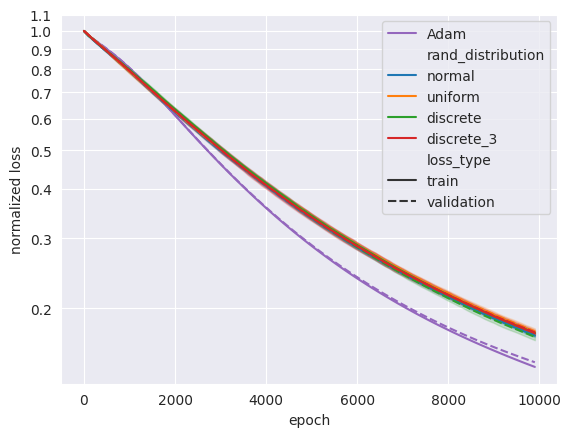

In [3]:
adam_train_losses = np.load(results_dir / 'adam' / 'clip_norm_False-20250612_154706' / 'train_losses.npy')
adam_validation_losses = np.load(results_dir / 'adam' / 'clip_norm_False-20250612_154706' / 'validation_losses.npy')
fig, ax = plt.subplots()
ax.plot(np.arange(0, len(adam_train_losses), 100), adam_train_losses[::100] / adam_train_losses[0], label='Adam', color='tab:purple')
ax.plot(np.arange(0, len(adam_validation_losses), 100), adam_validation_losses[::100] / adam_validation_losses[0], linestyle='dashed', color='tab:purple')
sns.lineplot(
    data=plot_data[(plot_data['rank'] == 8) & (~plot_data['clip_norm'])][::100],
    x='epoch',
    y='loss',
    hue='rand_distribution',
    style='loss_type',
    ax=ax,
)
ax.set(yscale='log')
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_ylabel('normalized loss')
fig.savefig('rand_projections.pdf', bbox_inches='tight')

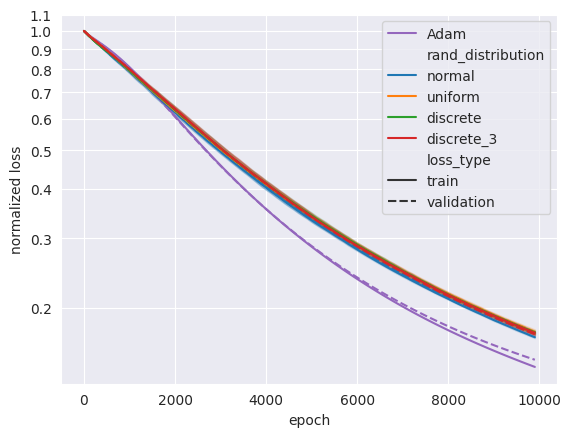

In [4]:
adam_train_losses = np.load(results_dir / 'adam' / 'clip_norm_True-20250612_154749' / 'train_losses.npy')
adam_validation_losses = np.load(results_dir / 'adam' / 'clip_norm_True-20250612_154749' / 'validation_losses.npy')
fig, ax = plt.subplots()
ax.plot(np.arange(0, len(adam_train_losses), 100), adam_train_losses[::100] / adam_train_losses[0], label='Adam', color='tab:purple')
ax.plot(np.arange(0, len(adam_validation_losses), 100), adam_validation_losses[::100] / adam_validation_losses[0], linestyle='dashed', color='tab:purple')
sns.lineplot(
    data=plot_data[(plot_data['rank'] == 8) & (plot_data['clip_norm'])][::100],
    x='epoch',
    y='loss',
    hue='rand_distribution',
    style='loss_type',
    ax=ax,
)
ax.set(yscale='log')
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_ylabel('normalized loss')
fig.savefig('grad_clip.pdf', bbox_inches='tight')

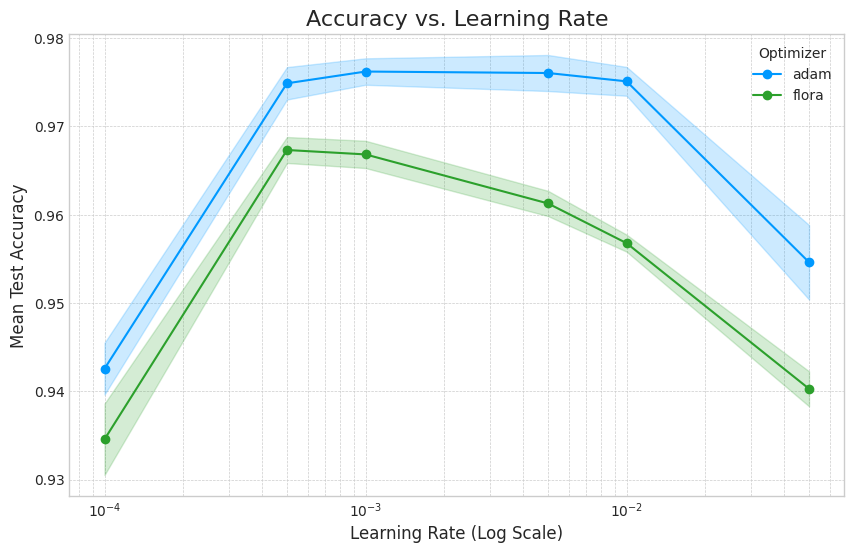

In [12]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# --- Configuration ---

# Set the base path to your results directory
BASE_RESULTS_PATH = pathlib.Path('results-lr')

# Define the optimizers you want to plot
OPTIMIZERS = ['adam', 'flora']

# Define colors for each optimizer
COLORS = {'adam': '#0099ff', 'flora': '#2ca02c'}

# V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V
# EDIT THESE LISTS to specify which learning rates and seeds to include
TESTED_LRS = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
TESTED_SEEDS = [42, 123, 888]
# ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^

# --- 1. Data Aggregation ---

aggregated_accuracies = defaultdict(lambda: defaultdict(list))

# Loop through each optimizer directory
for optimizer in OPTIMIZERS:
    optimizer_path = BASE_RESULTS_PATH / optimizer
    if not optimizer_path.is_dir():
        print(f"Warning: Directory not found for optimizer '{optimizer}', skipping.")
        continue

    # Loop through each individual experiment run directory
    for run_dir in optimizer_path.iterdir():
        if not run_dir.is_dir():
            continue

        # --- NEW PARSING METHOD (as requested) ---
        parts = run_dir.name.split('-')
        
        # Initialize variables to None
        lr = None
        seed = None

        # Loop through each part of the directory name (e.g., 'lr_0.001', 'seed_42')
        for part in parts:
            try:
                if part.startswith('lr_'):
                    lr = float(part[len('lr_'):])
                elif part.startswith('seed_'):
                    seed = int(part[len('seed_'):])
            except (ValueError, TypeError):
                print(f"Warning: Could not parse value from '{part}' in directory '{run_dir.name}'. Skipping this directory.")
                # Set both to None to ensure this directory is skipped
                lr, seed = None, None
                break
        
        # If we couldn't find both a learning rate and a seed, skip this directory
        if lr is None or seed is None:
            continue
        # --- END OF NEW PARSING METHOD ---


        # Filter based on the predefined lists
        if lr not in TESTED_LRS or seed not in TESTED_SEEDS:
            continue

        # If the run passes the filter, load its data
        acc_file = run_dir / "validation_accs.npy"
        if acc_file.exists():
            try:
                accs = np.load(acc_file)
                final_accuracy = accs[-1] # Use the final accuracy
                aggregated_accuracies[optimizer][lr].append(final_accuracy)
            except Exception as e:
                print(f"Error loading or processing {acc_file}: {e}")


# --- 2. Data Processing for Plotting ---
# (This section remains unchanged)
plot_data = defaultdict(lambda: {'lrs': [], 'means': [], 'stds': []})
for optimizer, lr_data in aggregated_accuracies.items():
    sorted_lrs = sorted(lr_data.keys())
    for lr in sorted_lrs:
        accuracies = lr_data[lr]
        if len(accuracies) > 0:
            plot_data[optimizer]['lrs'].append(lr)
            plot_data[optimizer]['means'].append(np.mean(accuracies))
            plot_data[optimizer]['stds'].append(np.std(accuracies))
        else:
             print(f"Warning: No valid runs found for {optimizer} with lr={lr} after filtering.")

# --- 3. Plotting ---
# (This section remains unchanged)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
for optimizer, data in plot_data.items():
    lrs = np.array(data['lrs'])
    means = np.array(data['means'])
    stds = np.array(data['stds'])
    color = COLORS.get(optimizer, 'black')
    ax.plot(lrs, means, marker='o', linestyle='-', label=optimizer, color=color)
    ax.fill_between(lrs, means - stds, means + stds, color=color, alpha=0.2)

# --- 4. Final Touches ---
# (This section remains unchanged)
ax.set_xscale('log')
ax.set_title('Accuracy vs. Learning Rate', fontsize=16)
ax.set_xlabel('Learning Rate (Log Scale)', fontsize=12)
ax.set_ylabel('Mean Test Accuracy', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(title='Optimizer')
plt.show()
fig.savefig('learning_rate.pdf', bbox_inches='tight')

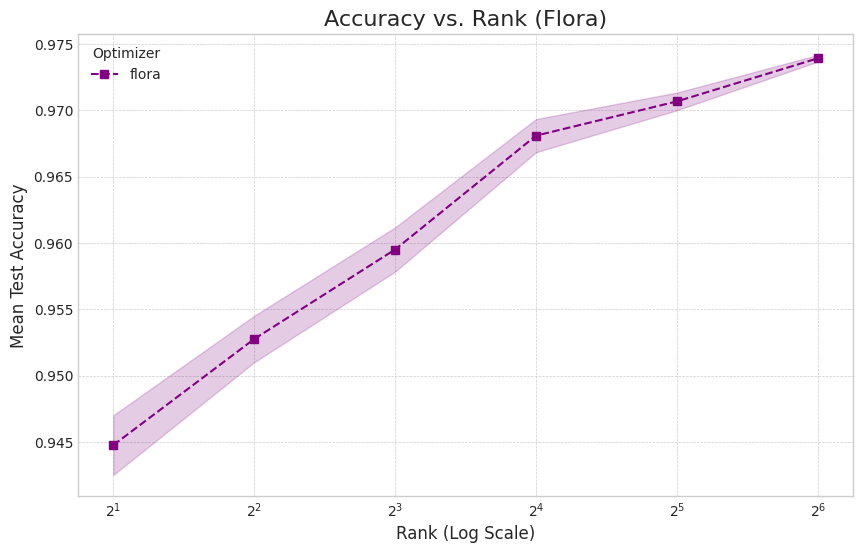

In [14]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# --- Configuration ---

# Set the base path to your results directory
# The script will look inside 'results/flora/'
BASE_RESULTS_PATH = pathlib.Path('results')

# Define the optimizer(s) you want to plot
OPTIMIZERS = ['flora']

# Define the visual style for the plot
# You can easily change color, marker style, and line style here
STYLES = {
    'flora': {
        'color': '#800080',  # Purple
        'marker': 's',       # Square
        'linestyle': 'dashed'
    }
}

# V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V V
# EDIT THESE LISTS to specify which ranks and seeds to include
TESTED_RANKS = [2, 4, 8, 16, 32, 64]  # Example ranks (2^1 to 2^6)
TESTED_SEEDS = [42, 123, 888]        # Example seeds
# ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^


# --- 1. Data Aggregation ---

# This will store accuracies grouped by optimizer and rank:
# {optimizer: {rank: [acc1, acc2, ...]}}
aggregated_accuracies = defaultdict(lambda: defaultdict(list))

# Loop through each optimizer directory (in this case, just 'flora')
for optimizer in OPTIMIZERS:
    optimizer_path = BASE_RESULTS_PATH / optimizer
    if not optimizer_path.is_dir():
        print(f"Warning: Directory not found for optimizer '{optimizer}', skipping.")
        continue

    # Loop through each individual experiment run directory
    for run_dir in optimizer_path.iterdir():
        if not run_dir.is_dir():
            continue

        # Use the string-splitting method to parse parameters
        parts = run_dir.name.split('-')
        
        rank = None
        seed = None

        # Loop through each part of the directory name (e.g., 'rank_8', 'seed_42')
        for part in parts:
            try:
                if part.startswith('rank_'):
                    rank = int(part[len('rank_'):])
                elif part.startswith('seed_'):
                    seed = int(part[len('seed_'):])
            except (ValueError, TypeError):
                print(f"Warning: Could not parse value from '{part}' in '{run_dir.name}'. Skipping.")
                rank, seed = None, None
                break
        
        # If we couldn't find both a rank and a seed, skip this directory
        if rank is None or seed is None:
            continue

        # Filter based on the predefined lists of ranks and seeds
        if rank not in TESTED_RANKS or seed not in TESTED_SEEDS:
            continue

        # If the run passes the filter, load its accuracy data
        acc_file = run_dir / "validation_accs.npy"
        if acc_file.exists():
            try:
                accs = np.load(acc_file)
                final_accuracy = accs[-1] # Use the final accuracy
                aggregated_accuracies[optimizer][rank].append(final_accuracy)
            except Exception as e:
                print(f"Error loading or processing {acc_file}: {e}")

# --- 2. Data Processing for Plotting ---
plot_data = defaultdict(lambda: {'ranks': [], 'means': [], 'stds': []})

for optimizer, rank_data in aggregated_accuracies.items():
    # Sort by rank to ensure the line plot connects points correctly
    sorted_ranks = sorted(rank_data.keys())
    
    for rank in sorted_ranks:
        accuracies = rank_data[rank]
        if len(accuracies) > 0:
            plot_data[optimizer]['ranks'].append(rank)
            plot_data[optimizer]['means'].append(np.mean(accuracies))
            plot_data[optimizer]['stds'].append(np.std(accuracies))
        else:
             print(f"Warning: No valid runs found for {optimizer} with rank={rank} after filtering.")

# --- 3. Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

for optimizer, data in plot_data.items():
    ranks = np.array(data['ranks'])
    means = np.array(data['means'])
    stds = np.array(data['stds'])
    style = STYLES.get(optimizer, {}) # Get style or empty dict
    
    # Plot the mean accuracy line with specified styles
    ax.plot(
        ranks,
        means,
        label=optimizer,
        color=style.get('color'),
        marker=style.get('marker'),
        linestyle=style.get('linestyle')
    )
    
    # Create the shaded area for variance (mean ± std)
    ax.fill_between(
        ranks,
        means - stds,
        means + stds,
        color=style.get('color'),
        alpha=0.2
    )

# --- 4. Final Touches ---

# Set the x-axis to a logarithmic scale with base 2
ax.set_xscale('log', base=2)

# Set labels and title to match the example image
ax.set_title('Accuracy vs. Rank (Flora)', fontsize=16)
ax.set_xlabel('Rank (Log Scale)', fontsize=12)
ax.set_ylabel('Mean Test Accuracy', fontsize=12)

# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add the legend
ax.legend(title='Optimizer')

plt.show()
fig.savefig('rank.pdf', bbox_inches='tight')